In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [10]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
trans = pd.read_csv('../data/transactions.csv')

In [11]:
# Convert date columns
trans['doj'] = pd.to_datetime(trans['doj'])
trans['doi'] = pd.to_datetime(trans['doi'])

# Optional: convert to category to save memory and improve speed
cat_cols = ['srcid_region', 'destid_region', 'srcid_tier', 'destid_tier']
for col in cat_cols:
    trans[col] = trans[col].astype('category')

In [14]:
# Convert date column to datetime
train['doj'] = pd.to_datetime(train['doj'])

dbd_15 = trans[trans['dbd'] == 15].copy()

# Also convert for filtered dbd_15
dbd_15['doj'] = pd.to_datetime(dbd_15['doj'])

# Merge on srcid, destid, doj to get final_seatcount (the target)
train_merged = pd.merge(dbd_15, train, on=['doj', 'srcid', 'destid'], how='left')

In [16]:
#diagnosis for null values
missing_rows = dbd_15[~dbd_15.set_index(['doj', 'srcid', 'destid']).index
                      .isin(train.set_index(['doj', 'srcid', 'destid']).index)]

train_merged = train_merged.dropna(subset=['final_seatcount'])
print("Training rows after dropping nulls:", len(train_merged))

Training rows after dropping nulls: 67200


In [18]:
train_merged['weekday'] = train_merged['doj'].dt.dayofweek
train_merged['month'] = train_merged['doj'].dt.month

# Rename to make it clear these are 15-day-before features
train_merged.rename(columns={
    'cumsum_seatcount': 'seats_15_days_before',
    'cumsum_searchcount': 'searches_15_days_before'
}, inplace=True)

# Add derived feature
train_merged['search_to_seat_ratio'] = train_merged['searches_15_days_before'] / (train_merged['seats_15_days_before'] + 1e-5)

# Average bookings per route-month
route_month_avg = train_merged.groupby(['srcid', 'destid', 'month'])['final_seatcount'].mean().reset_index()
route_month_avg.rename(columns={'final_seatcount': 'route_month_avg'}, inplace=True)

# Average bookings per route-weekday
route_weekday_avg = train_merged.groupby(['srcid', 'destid', 'weekday'])['final_seatcount'].mean().reset_index()
route_weekday_avg.rename(columns={'final_seatcount': 'route_weekday_avg'}, inplace=True)

train_merged = train_merged.merge(route_month_avg, on=['srcid', 'destid', 'month'], how='left')
train_merged = train_merged.merge(route_weekday_avg, on=['srcid', 'destid', 'weekday'], how='left')

In [20]:
!pip install holidays
import holidays
import pandas as pd

# Use India holidays from the library
indian_holidays = holidays.India(years=[2023, 2024])  # include relevant years

# is_holiday
train_merged['is_holiday'] = train_merged['doj'].dt.date.isin(indian_holidays).astype(int)

# is_day_before_holiday
train_merged['is_day_before_holiday'] = train_merged['doj'].apply(lambda x: (x + pd.Timedelta(days=1)) in indian_holidays).astype(int)

# is_long_weekend: holiday on Friday or Monday
train_merged['is_long_weekend'] = train_merged['doj'].apply(
    lambda x: ((x - pd.Timedelta(days=1)) in indian_holidays and x.weekday() == 5) or  # Saturday after Friday holiday
              ((x + pd.Timedelta(days=1)) in indian_holidays and x.weekday() == 4) or  # Friday before Saturday holiday
              ((x - pd.Timedelta(days=2)) in indian_holidays and x.weekday() == 6) or  # Sunday after Friday holiday
              ((x + pd.Timedelta(days=2)) in indian_holidays and x.weekday() == 5)     # Saturday before Monday holiday
).astype(int)

# Basic pan-India school vacation periods
train_merged['month'] = train_merged['doj'].dt.month
train_merged['is_school_vacation'] = train_merged['month'].isin([4, 5, 6, 10, 11, 12]).astype(int)

# Define Diwali dates
diwali_dates = [pd.Timestamp("2023-11-12"), pd.Timestamp("2024-11-01")]

# Create feature: is_diwali_week (±3 days)
train_merged['is_diwali_week'] = train_merged['doj'].apply(
    lambda x: any([(diwali - pd.Timedelta(days=3)) <= x <= (diwali + pd.Timedelta(days=3)) for diwali in diwali_dates])
).astype(int)

# Create feature: is_festival_cluster_state
train_merged['is_festival_cluster_state'] = train_merged.apply(
    lambda row: (
        (row['srcid_region'] in ['Tamil Nadu', 'Delhi'] or row['destid_region'] in ['Tamil Nadu', 'Delhi'])
        and row['doj'].month in [10, 11]
    ), axis=1
).astype(int)

In [21]:
region_to_state = {
    'Tamil Nadu': 'Tamil Nadu',
    'Andhra Pradesh': 'Andhra Pradesh',
    'Maharashtra and Goa': 'Maharashtra',
    'Karnataka': 'Karnataka',
    'Delhi': 'Delhi',
    'Rest of North': 'Uttar Pradesh',
    'East 1': 'West Bengal',
    'Madhya Pradesh': 'Madhya Pradesh',
    'Rajasthan': 'Rajasthan',
    'Kerala': 'Kerala'
}

import holidays

def get_state_holidays(region_col, date_col):
    holiday_flags = []
    for region, date in zip(train_merged[region_col], train_merged[date_col]):
        state = region_to_state.get(region, None)
        if state:
            state_holidays = holidays.India(years=[2023, 2024], subdiv=state)
            holiday_flags.append(int(date in state_holidays))
        else:
            holiday_flags.append(0)
    return holiday_flags

# For source and destination regions
train_merged['is_src_region_holiday'] = get_state_holidays('srcid_region', 'doj')
train_merged['is_dest_region_holiday'] = get_state_holidays('destid_region', 'doj')

train_merged['is_any_region_holiday'] = train_merged[['is_src_region_holiday', 'is_dest_region_holiday']].max(axis=1)


In [22]:
train_merged['intra_region'] = (train_merged['srcid_region'] == train_merged['destid_region']).astype(int)

train_merged['same_tier'] = (train_merged['srcid_tier'] == train_merged['destid_tier']).astype(int)

In [24]:
train_merged['weekday_month'] = train_merged['weekday'].astype(str) + '_' + train_merged['month'].astype(str)

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train_merged['weekday_month_encoded'] = le.fit_transform(train_merged['weekday_month'])

train_merged['tier_pair'] = train_merged['srcid_tier'].astype(str) + '_' + train_merged['destid_tier'].astype(str)
train_merged['tier_pair_encoded'] = le.fit_transform(train_merged['tier_pair'])

train_merged['region_pair'] = train_merged['srcid_region'].astype(str) + '_' + train_merged['destid_region'].astype(str)
train_merged['region_pair_encoded'] = le.fit_transform(train_merged['region_pair'])

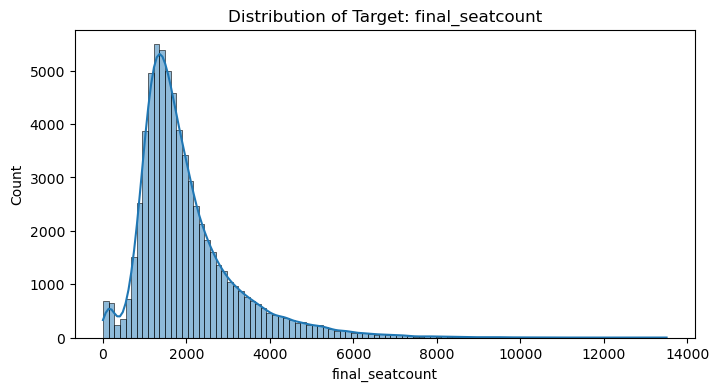

Skewness of final_seatcount: 1.91


In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.histplot(train_merged['final_seatcount'], bins=100, kde=True)
plt.title("Distribution of Target: final_seatcount")
plt.xlabel("final_seatcount")
plt.show()

from scipy.stats import skew

skewness = skew(train_merged['final_seatcount'])
print(f"Skewness of final_seatcount: {skewness:.2f}")

In [25]:
from sklearn.model_selection import train_test_split

# Select feature columns (exclude route_key and target)
features = [
    'seats_15_days_before', 'searches_15_days_before', 'search_to_seat_ratio',
    'weekday', 'month', 'same_tier', 'intra_region', 'is_school_vacation',
    'is_holiday', 'is_day_before_holiday', 'is_long_weekend',
    'is_festival_cluster_state', 'is_diwali_week',
    'route_month_avg','weekday_month_encoded', 'tier_pair_encoded', 'region_pair_encoded'
]

X = train_merged[features]
y = train_merged['final_seatcount']

# Split 80% train, 20% validation
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [40]:
param_grid = {
    'num_leaves': [15, 31, 63],
    'max_depth': [-1, 5, 10, 20],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 500],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Initialize model
model = LGBMRegressor(random_state=42)

# Random search
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=25,  # try 25 different combinations
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

# Best model and score
best_model = random_search.best_estimator_
print("Best Params:", random_search.best_params_)

# Evaluate
y_pred = best_model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"RMSE on Validation Set: {rmse:.2f}")

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008578 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1172
[LightGBM] [Info] Number of data points in the train set: 35840, number of used features: 17
[LightGBM] [Info] Start training from score 2005.191685
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010338 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1172
[LightGBM] [Info] Number of data points in the train set: 35840, number of used features: 17
[LightGBM] [Info] Start training from score 2005.191685
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008605 seconds.
You can set `forc

In [64]:
#training on test data

test['doj'] = pd.to_datetime(test['doj'])
dbd_15 = trans[trans['dbd'] == 15].copy()
dbd_15['doj'] = pd.to_datetime(dbd_15['doj'])

test_merged = pd.merge(test, dbd_15, on=['doj', 'srcid', 'destid'], how='left')

test_merged.head()

,route_key,doj,srcid,destid,doi,srcid_region,destid_region,srcid_tier,destid_tier,cumsum_seatcount,cumsum_searchcount,dbd
0,2025-02-11_46_45,2025-02-11,46,45,2025-01-27,Tamil Nadu,Karnataka,Tier 1,Tier 1,38.0,1082.0,15
1,2025-01-20_17_23,2025-01-20,17,23,2025-01-05,East 1,East 1,Tier2,Tier 1,0.0,1175.0,15
2,2025-01-08_02_14,2025-01-08,2,14,2024-12-24,Maharashtra and Goa,Maharashtra and Goa,Tier 1,Tier2,0.0,370.0,15
3,2025-01-08_08_47,2025-01-08,8,47,2024-12-24,Andhra Pradesh,Andhra Pradesh,Tier2,Tier 1,0.0,120.0,15
4,2025-01-08_09_46,2025-01-08,9,46,2024-12-24,Tamil Nadu,Tamil Nadu,Tier2,Tier 1,39.0,1230.0,15


In [66]:
#feature engineering

# Calendar features
test_merged['doj'] = pd.to_datetime(test_merged['doj'])
test_merged['weekday'] = test_merged['doj'].dt.dayofweek
test_merged['month'] = test_merged['doj'].dt.month

test_merged.rename(columns={
    'cumsum_seatcount': 'seats_15_days_before',
    'cumsum_searchcount': 'searches_15_days_before'
}, inplace=True)

# Ratio feature
test_merged['search_to_seat_ratio'] = test_merged['searches_15_days_before'] / (test_merged['seats_15_days_before'] + 1)

# Same tier
test_merged['same_tier'] = (test_merged['srcid_tier'] == test_merged['destid_tier']).astype(int)

# Intra region
test_merged['intra_region'] = (test_merged['srcid_region'] == test_merged['destid_region']).astype(int)

# School vacation
test_merged['is_school_vacation'] = test_merged['month'].isin([4, 5, 6, 12, 1]).astype(int)

# Holiday features (assuming you've already imported `holidays`)
indian_holidays = holidays.India(years=[2024, 2025])
test_merged['is_holiday'] = test_merged['doj'].isin(indian_holidays).astype(int)
test_merged['is_day_before_holiday'] = test_merged['doj'].apply(lambda x: (x + pd.Timedelta(days=1)) in indian_holidays).astype(int)
test_merged['is_long_weekend'] = test_merged['doj'].apply(
    lambda x: ((x - pd.Timedelta(days=1)) in indian_holidays and x.weekday() == 5) or
              ((x + pd.Timedelta(days=1)) in indian_holidays and x.weekday() == 4) or
              ((x - pd.Timedelta(days=2)) in indian_holidays and x.weekday() == 6) or
              ((x + pd.Timedelta(days=2)) in indian_holidays and x.weekday() == 5)
).astype(int)

# Festival cluster state (Tamil Nadu or Delhi during Oct-Nov)
test_merged['is_festival_cluster_state'] = (
    (test_merged['month'].isin([10, 11])) &
    (test_merged['srcid_region'].isin(['Tamil Nadu', 'Delhi']))
).astype(int)

# Diwali week
diwali_dates = pd.to_datetime([
    '2023-11-12', '2024-11-01'  # Adjust if other years are present
])
test_merged['is_diwali_week'] = test_merged['doj'].apply(
    lambda x: any(abs((x - d).days) <= 3 for d in diwali_dates)
).astype(int)

# 1. Compute route-level features from TRAIN data
route_month_avg = train_merged.groupby(['srcid', 'destid', 'month'])['final_seatcount'].mean().reset_index()
route_month_avg.rename(columns={'final_seatcount': 'route_month_avg'}, inplace=True)

route_weekday_avg = train_merged.groupby(['srcid', 'destid', 'weekday'])['final_seatcount'].mean().reset_index()
route_weekday_avg.rename(columns={'final_seatcount': 'route_weekday_avg'}, inplace=True)

# 2. Merge with TEST data
test_merged = pd.merge(test_merged, route_month_avg, on=['srcid', 'destid', 'month'], how='left')
test_merged = pd.merge(test_merged, route_weekday_avg, on=['srcid', 'destid', 'weekday'], how='left')

# Recalculate the ratio
test_merged['search_to_seat_ratio'] = test_merged['searches_15_days_before'] / (test_merged['seats_15_days_before'] + 1e-5)
test_merged['search_to_seat_ratio'] = test_merged['search_to_seat_ratio'].clip(upper=500)

/var/folders/d1/z6988h613vvdthdkgbg645gw0000gn/T/ipykernel_76995/2729663278.py:27: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  test_merged['is_holiday'] = test_merged['doj'].isin(indian_holidays).astype(int)


In [70]:
test_merged['weekday_month'] = test_merged['weekday'].astype(str) + '_' + test_merged['month'].astype(str)

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
test_merged['weekday_month_encoded'] = le.fit_transform(test_merged['weekday_month'])

test_merged['tier_pair'] = test_merged['srcid_tier'].astype(str) + '_' + test_merged['destid_tier'].astype(str)
test_merged['tier_pair_encoded'] = le.fit_transform(test_merged['tier_pair'])

test_merged['region_pair'] = test_merged['srcid_region'].astype(str) + '_' + test_merged['destid_region'].astype(str)
test_merged['region_pair_encoded'] = le.fit_transform(test_merged['region_pair'])

In [72]:
test_merged.columns

Index(['route_key', 'doj', 'srcid', 'destid', 'doi', 'srcid_region',
       'destid_region', 'srcid_tier', 'destid_tier', 'seats_15_days_before',
       'searches_15_days_before', 'dbd', 'weekday', 'month',
       'search_to_seat_ratio', 'same_tier', 'intra_region',
       'is_school_vacation', 'is_holiday', 'is_day_before_holiday',
       'is_long_weekend', 'is_festival_cluster_state', 'is_diwali_week',
       'route_month_avg', 'route_weekday_avg', 'weekday_month',
       'weekday_month_encoded', 'tier_pair', 'tier_pair_encoded',
       'region_pair', 'region_pair_encoded'],
      dtype='object')

In [74]:
features = [
    'seats_15_days_before', 'searches_15_days_before', 'search_to_seat_ratio',
    'weekday', 'month', 'same_tier', 'intra_region', 'is_school_vacation',
    'is_holiday', 'is_day_before_holiday', 'is_long_weekend',
    'is_festival_cluster_state', 'is_diwali_week',
    'route_month_avg','weekday_month_encoded', 'tier_pair_encoded', 'region_pair_encoded'
]

import pandas as pd

# 1. Ensure test set has only the required features
X_test = test_merged[features]

# 2. Predict using the best model
test_preds = best_model.predict(X_test)

# 3. Clip negative predictions if needed (seat count can't be negative)
test_preds = np.maximum(test_preds, 0)

# 4. Create submission DataFrame
submission = pd.DataFrame({
    'route_key': test_merged['route_key'],
    'final_seatcount': test_preds
})

# 5. Round to nearest integer if required
submission['final_seatcount'] = submission['final_seatcount'].round().astype(int)

# 6. Save to CSV
submission.to_csv("submission.csv", index=False)